In [1]:
import tarfile

#Download from site http://host.robots.ox.ac.uk/pascal/VOC/voc2007/ --> open --> extract
tf = tarfile.open("C:\\Users\\deep\\object_detection\\pascal_voc\\VOCtrainval_06-Nov-2007.tar")
tf.extractall()

In [2]:
tf.getnames()[:5]

['VOCdevkit',
 'VOCdevkit/VOC2007',
 'VOCdevkit/VOC2007/Annotations',
 'VOCdevkit/VOC2007/Annotations/000005.xml',
 'VOCdevkit/VOC2007/Annotations/000007.xml']

In [3]:
#collect all xml and jpeg files and count
len([e for e in tf.getnames() if e.endswith('xml')]), len([e for e in tf.getnames() if e.endswith('jpg')])

(5011, 5011)

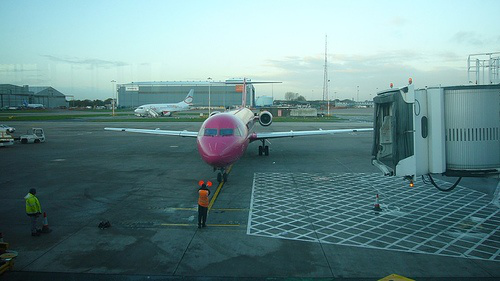

In [4]:
#view an image --> filename given in xml file
from PIL import Image


def show_pil_img(img_file):
    path = 'VOCdevkit/VOC2007/JPEGImages/' + img_file
    indx = tf.getnames().index(path)          # tf.getnames().index('VOCdevkit/VOC2007/JPEGImages/000032.jpg') #5101
    return Image.open((tf.getnames()[indx]))  # Image.open(tf.getnames()[5101])
    
show_pil_img('000032.jpg')

In [5]:
#The key function that pulls out the most important imformation about eevery object in an image
#xml_file = tf.getnames()[16]


import xml.etree.ElementTree as ET

def read_xml(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    img_cat_bbox = []
    

    for dim in root.find('size'):    #Gives all dimensions
        
        sizes = []
        if dim.tag =='width':
            img_width = dim.text
            
        elif dim.tag =='height':
            img_height = dim.text
        
    for x in root.iter('object'):
        temp = []
        for xx in x:
        

            if xx.tag =='name':
                                
                temp.append(root.find('filename').text)
                temp.append(int(img_width))#, int(img_height))
                temp.append(int(img_height))
                temp.append(xx.text)
            if xx.tag =='bndbox':
                
                
                for yy in xx:
                    
                    temp.append(int(yy.text))
                
                img_cat_bbox.append(temp)
    return (img_cat_bbox)

In [6]:
xml_file = tf.getnames()[16] #--> xml file in idx 16
read_xml(xml_file)

[['000032.jpg', 500, 281, 'aeroplane', 104, 78, 375, 183],
 ['000032.jpg', 500, 281, 'aeroplane', 133, 88, 197, 123],
 ['000032.jpg', 500, 281, 'person', 195, 180, 213, 229],
 ['000032.jpg', 500, 281, 'person', 26, 189, 44, 238]]

In [7]:
#Use xml reader to get information from all the xml files, also save the index in sublist
import numpy as np

image_info1 = []

for i in range(3, 5014):
    file_info = read_xml(tf.getnames()[i])
    idx_copied = [[i]]*len(file_info)
    join_idx_info = list(map(lambda x, y:x + y, idx_copied, file_info))
    image_info1.append(join_idx_info)

#Info for each image are contained in seperate sublist, unpack them
image_info = [item for sublist in image_info1 for item in sublist]
image_info[:6]

[[3, '000005.jpg', 500, 375, 'chair', 263, 211, 324, 339],
 [3, '000005.jpg', 500, 375, 'chair', 165, 264, 253, 372],
 [3, '000005.jpg', 500, 375, 'chair', 5, 244, 67, 374],
 [3, '000005.jpg', 500, 375, 'chair', 241, 194, 295, 299],
 [3, '000005.jpg', 500, 375, 'chair', 277, 186, 312, 220],
 [4, '000007.jpg', 500, 333, 'car', 141, 50, 500, 330]]

In [8]:
#Shift to pandas --> Do all further computation in pandas

import pandas as pd

cols = ['xml_id', 'img_f', 'width', 'height', 'obj_cla', 'xmin', 'ymin', 'xmax', 'ymax']
first_df = pd.DataFrame(image_info, columns = cols)
first_df.head()

,xml_id,img_f,width,height,obj_cla,xmin,ymin,xmax,ymax
0,3,000005.jpg,500,375,chair,263,211,324,339
1,3,000005.jpg,500,375,chair,165,264,253,372
2,3,000005.jpg,500,375,chair,5,244,67,374
3,3,000005.jpg,500,375,chair,241,194,295,299
4,3,000005.jpg,500,375,chair,277,186,312,220


In [9]:
#Resize to 416 x 416 --> find resized corordinates for bounding boxes and all other necessary items
# 'r' --> resized (and rounded)

new_w_l = 416
new_size = 416

first_df['xmin_r'] = round(first_df['xmin'] * (new_w_l/first_df['width']))
first_df['ymin_r'] = round(first_df['ymin'] * (new_w_l/first_df['height']))
first_df['xmax_r'] = round(first_df['xmax'] * (new_w_l/first_df['width']))
first_df['ymax_r'] = round(first_df['ymax'] * (new_w_l/first_df['height']))

#Finding the mid_pt or center--> in cooridnates --> in resized scale
first_df['mid_x'] = round((first_df['xmax_r'] - first_df['xmin_r'])/2 + first_df['xmin_r'])
first_df['mid_y'] = round((first_df['ymax_r'] - first_df['ymin_r'])/2 + first_df['ymin_r'])

#Size of bbox width and height --> rescaled wrt new image size
first_df['w_size'] = round((first_df['xmax'] - first_df['xmin'])*new_w_l/first_df['width'])
first_df['h_size'] = round((first_df['ymax'] - first_df['ymin'])*new_w_l/first_df['height'])

#Relative location of mid_pts (centre) and relative size of w/h --> wrt whole image and not grid
first_df['x_r'] = first_df['mid_x']/new_size
first_df['y_r'] = first_df['mid_y']/new_size
first_df['w_r'] = first_df['w_size']/new_size
first_df['h_r'] = first_df['h_size']/new_size

In [10]:
#x_r, y_r --> relative position of the center of an object
#w_r, h_r --> relative size of the object

first_df.head()

,xml_id,img_f,width,height,obj_cla,xmin,ymin,xmax,ymax,xmin_r,...,xmax_r,ymax_r,mid_x,mid_y,w_size,h_size,x_r,y_r,w_r,h_r
0,3,000005.jpg,500,375,chair,263,211,324,339,219.0,...,270.0,376.0,244.0,305.0,51.0,142.0,0.586538,0.733173,0.122596,0.341346
1,3,000005.jpg,500,375,chair,165,264,253,372,137.0,...,210.0,413.0,174.0,353.0,73.0,120.0,0.418269,0.848558,0.175481,0.288462
2,3,000005.jpg,500,375,chair,5,244,67,374,4.0,...,56.0,415.0,30.0,343.0,52.0,144.0,0.072115,0.824519,0.125000,0.346154
3,3,000005.jpg,500,375,chair,241,194,295,299,201.0,...,245.0,332.0,223.0,274.0,45.0,116.0,0.536058,0.658654,0.108173,0.278846
4,3,000005.jpg,500,375,chair,277,186,312,220,230.0,...,260.0,244.0,245.0,225.0,29.0,38.0,0.588942,0.540865,0.069712,0.091346


In [11]:
first_df[["xml_id", "img_f", "obj_cla", "x_r", "y_r", "w_r", "h_r"]].head()

,xml_id,img_f,obj_cla,x_r,y_r,w_r,h_r
0,3,000005.jpg,chair,0.586538,0.733173,0.122596,0.341346
1,3,000005.jpg,chair,0.418269,0.848558,0.175481,0.288462
2,3,000005.jpg,chair,0.072115,0.824519,0.125000,0.346154
3,3,000005.jpg,chair,0.536058,0.658654,0.108173,0.278846
4,3,000005.jpg,chair,0.588942,0.540865,0.069712,0.091346


In [12]:
from collections import OrderedDict
#Integers coding of objects classes

#Make 2 dictionaries for indexing objects and vice versa
all_obj= (list(set(first_df.obj_cla)))
sorted_obj = sorted(all_obj)
ix_2_ob = OrderedDict(zip([i for i in range(len(sorted_obj))], sorted_obj))
ob_2_ix = OrderedDict(zip(sorted_obj, [i for i in range(len(sorted_obj))]))

#Make a list which translates all objects in dataframe to integer categories
obj_cat_all = [ob_2_ix.get(key) for key in first_df.obj_cla]

#Finally update the table to include objects as integers
first_df.insert(5, 'obj_cat', obj_cat_all)

In [13]:
first_df.head()

,xml_id,img_f,width,height,obj_cla,obj_cat,xmin,ymin,xmax,ymax,...,xmax_r,ymax_r,mid_x,mid_y,w_size,h_size,x_r,y_r,w_r,h_r
0,3,000005.jpg,500,375,chair,8,263,211,324,339,...,270.0,376.0,244.0,305.0,51.0,142.0,0.586538,0.733173,0.122596,0.341346
1,3,000005.jpg,500,375,chair,8,165,264,253,372,...,210.0,413.0,174.0,353.0,73.0,120.0,0.418269,0.848558,0.175481,0.288462
2,3,000005.jpg,500,375,chair,8,5,244,67,374,...,56.0,415.0,30.0,343.0,52.0,144.0,0.072115,0.824519,0.125000,0.346154
3,3,000005.jpg,500,375,chair,8,241,194,295,299,...,245.0,332.0,223.0,274.0,45.0,116.0,0.536058,0.658654,0.108173,0.278846
4,3,000005.jpg,500,375,chair,8,277,186,312,220,...,260.0,244.0,245.0,225.0,29.0,38.0,0.588942,0.540865,0.069712,0.091346


In [14]:
#Assigning anchor boxes --> to keep it simple, here just 2 anchor boxes are selected

#1 --> broad, 0 --> tall --> much fewer tall objects --> probablay needs better grouping
first_df['anchor'] = (first_df['w_size']/first_df['h_size'] > 1) * 1


#Assigning bounding boxes to grids --> img is divided into 9 (3x3) grids arbitrarily
#Both cell address (x,y) and  cell num --> starting top left --> right --> down --> down right --> grid number is found
#single pixel as center --> grid sie of 416 x 416, --> move from top left to bottom right as an alternative

#grid address as location
x_loc = (first_df['x_r']/0.33).astype(int)
y_loc = (first_df['y_r']/0.33).astype(int)
first_df['grid_a'] = list(zip(x_loc, y_loc))

#grid address as number (from 0 to 8, starting top-left, going left to right and down)
grid_n = x_loc  + y_loc * 3
first_df['grid_n'] = grid_n

#Center as single point/pixel
first_df['pix_pt'] = (first_df.mid_x + first_df.mid_y * 416).astype(int) #Not used here
#first_df.head()

In [15]:
first_df.head()

,xml_id,img_f,width,height,obj_cla,obj_cat,xmin,ymin,xmax,ymax,...,w_size,h_size,x_r,y_r,w_r,h_r,anchor,grid_a,grid_n,pix_pt
0,3,000005.jpg,500,375,chair,8,263,211,324,339,...,51.0,142.0,0.586538,0.733173,0.122596,0.341346,0,"(1, 2)",7,127124
1,3,000005.jpg,500,375,chair,8,165,264,253,372,...,73.0,120.0,0.418269,0.848558,0.175481,0.288462,0,"(1, 2)",7,147022
2,3,000005.jpg,500,375,chair,8,5,244,67,374,...,52.0,144.0,0.072115,0.824519,0.125000,0.346154,0,"(0, 2)",6,142718
3,3,000005.jpg,500,375,chair,8,241,194,295,299,...,45.0,116.0,0.536058,0.658654,0.108173,0.278846,0,"(1, 1)",4,114207
4,3,000005.jpg,500,375,chair,8,277,186,312,220,...,29.0,38.0,0.588942,0.540865,0.069712,0.091346,0,"(1, 1)",4,93845


In [16]:
first_df[["xml_id", "img_f", "obj_cat", "x_r", "y_r", "w_r", "h_r", "anchor", "grid_n"]].head()

,xml_id,img_f,obj_cat,x_r,y_r,w_r,h_r,anchor,grid_n
0,3,000005.jpg,8,0.586538,0.733173,0.122596,0.341346,0,7
1,3,000005.jpg,8,0.418269,0.848558,0.175481,0.288462,0,7
2,3,000005.jpg,8,0.072115,0.824519,0.125000,0.346154,0,6
3,3,000005.jpg,8,0.536058,0.658654,0.108173,0.278846,0,4
4,3,000005.jpg,8,0.588942,0.540865,0.069712,0.091346,0,4


In [17]:
#To check all derivations are correct --> resize the image and put the bounding box labeling center, anchor(orientation)
from IPython.display import display 
from PIL import ImageDraw
from PIL import ImageDraw, ImageFont


from torchvision import transforms
trans = transforms.Compose([transforms.Resize((416, 416))])

def write_bb(xml_id):
    sel_img_x = first_df[first_df['xml_id'] ==xml_id].iloc[:, np.r_[1, 4, 10:16, -4, -2]]
    pil_img = show_pil_img(sel_img_x.iloc[0, 0])
    #trans = transforms.Compose([transforms.Resize((416, 416))])
    im = trans(pil_img)
    
    draw = ImageDraw.Draw(im)
    #Draw a bounding box in resized image (using revised parameters) --> put the class of object at the center
    for i in range(sel_img_x.shape[0]):
        draw.rectangle(tuple(sel_img_x.iloc[i, 2:6].values), outline=(255, 255, 255))
        draw.text(tuple(sel_img_x.iloc[i, 6:8].values),sel_img_x.iloc[i, 1], stroke_width=0,  fill=(255,255,0,128))
        draw.text(tuple(sel_img_x.iloc[i, 6:8].values + (0, -10)),str(sel_img_x.iloc[i, -2]), stroke_width=0,  fill=(255,255,0,128))
        draw.text(tuple(sel_img_x.iloc[i, 6:8].values +(0, 10)),str(sel_img_x.iloc[i, -1]), stroke_width=0,  fill=(255,255,0,128))
    return im

#Put 3 x3 grid to verify that grids are correct
def draw_grid(size, img):
    w = img.size[0]
    h = w = img.size[1]
    get_cordinates = []
    draw = ImageDraw.Draw(img)
    
    for i in range(size):
        
        xmin_h = 0
        ymin_h = h//size * i
        xmax_h = w
        ymax_h = h//size * i
        draw.line((xmin_h, ymin_h, xmax_h, ymax_h), width = 2)
        
        xmin_v = w//size * i
        ymin_v = 0
        xmax_v = w//size * i
        ymax_v = h
        draw.line((xmin_v, ymin_v, xmax_v, ymax_v),  width = 1)
        
    return img

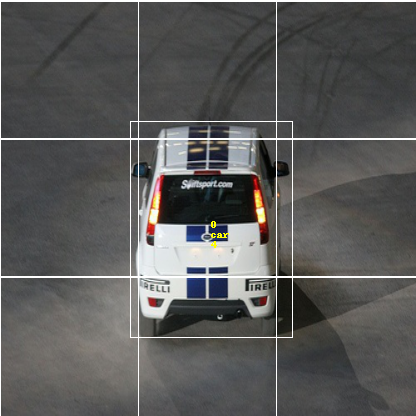

In [18]:
#Observe the grids that contain the object
#Similary print the grid, num and orintation of anchor
draw_grid(3, write_bb(6))

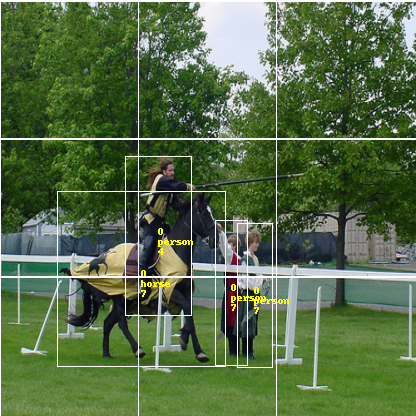

In [19]:
draw_grid(3, write_bb(5))

In [20]:
#Select all relevant info
vec_df_all = first_df[['xml_id', 'x_r', 'y_r', 'w_r', 'h_r', 'obj_cat', 'anchor', 'grid_n', 'obj_cla']]

#mark all the grids as 1 --> having object
vec_df_all.insert(loc=1, column='obj_yn', value=[1 for i in range(len(vec_df_all))])
vec_df_all.head()

,xml_id,obj_yn,x_r,y_r,w_r,h_r,obj_cat,anchor,grid_n,obj_cla
0,3,1,0.586538,0.733173,0.122596,0.341346,8,0,7,chair
1,3,1,0.418269,0.848558,0.175481,0.288462,8,0,7,chair
2,3,1,0.072115,0.824519,0.125000,0.346154,8,0,6,chair
3,3,1,0.536058,0.658654,0.108173,0.278846,8,0,4,chair
4,3,1,0.588942,0.540865,0.069712,0.091346,8,0,4,chair


In [21]:
#Reset the reference --> start from 0 --> so that it's easier to find which rows the objects belong
img_ref_dict_all = dict(zip(set(vec_df_all.xml_id), [i for i in range(len(set(vec_df_all.xml_id)))]))
xml_id_ref_all = [img_ref_dict_all.get(value) for value in vec_df_all.xml_id]
xml_id_ref_all[:5]

[0, 0, 0, 0, 0]

In [22]:
#Finally insert the ref
vec_df_all.insert(loc=1, column='xml_id_ref', value=xml_id_ref_all)
vec_df_all.head()

,xml_id,xml_id_ref,obj_yn,x_r,y_r,w_r,h_r,obj_cat,anchor,grid_n,obj_cla
0,3,0,1,0.586538,0.733173,0.122596,0.341346,8,0,7,chair
1,3,0,1,0.418269,0.848558,0.175481,0.288462,8,0,7,chair
2,3,0,1,0.072115,0.824519,0.125000,0.346154,8,0,6,chair
3,3,0,1,0.536058,0.658654,0.108173,0.278846,8,0,4,chair
4,3,0,1,0.588942,0.540865,0.069712,0.091346,8,0,4,chair


In [23]:
#Using above info, image number/ref and grid/anchor --> find which row the object appear--> while preparing large target tensor
vec_df_all['find_row'] = (vec_df_all.xml_id_ref * 18) + (vec_df_all.grid_n * 2) + (vec_df_all.anchor)
vec_df_all.head()

C:\Users\mnsho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,xml_id,xml_id_ref,obj_yn,x_r,y_r,w_r,h_r,obj_cat,anchor,grid_n,obj_cla,find_row
0,3,0,1,0.586538,0.733173,0.122596,0.341346,8,0,7,chair,14
1,3,0,1,0.418269,0.848558,0.175481,0.288462,8,0,7,chair,14
2,3,0,1,0.072115,0.824519,0.125000,0.346154,8,0,6,chair,12
3,3,0,1,0.536058,0.658654,0.108173,0.278846,8,0,4,chair,8
4,3,0,1,0.588942,0.540865,0.069712,0.091346,8,0,4,chair,8


In [24]:
#For each image there will be 9 x 2 sets of voctors --> each with 6 pieces of info
#presense of obj, center (x, y), size(h, w) and object class or category
#Target tensor will be of size num_images x 9 x 2 x 6
import torch

num_images = len(set(vec_df_all.xml_id))  #Unique images

to_fill = torch.zeros(num_images, 9, 2, 6).view(-1, 6)  #rows of vectors each containing 6 pieces of info, each img --> 18 rows

fill_idx_list_all = [int(i) for i in vec_df_all.find_row.tolist()]  #Find which row object belongs for each img

#Finally fill all the valid rows
for i in range(len(fill_idx_list_all)):

    to_fill[fill_idx_list_all[i]] = torch.FloatTensor(vec_df_all.iloc[i, np.r_[2, 3:8]])

In [25]:
#Note when there are duplicates for the same row --> same grid + same anchor/orientation --> later one replaces the earlier one
to_fill[:20]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.5889, 0.5409, 0.0697, 0.0913, 8.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0721, 0.8245, 0.1250, 0.3462, 8.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.4183, 0.8486, 0.1755, 0.2885, 8.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.000

In [26]:
#Create any piece of network
import torch.nn as nn

#Stage 1
def get_stg1():
    stg1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride =2, padding= (3, 3)),
                          nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
                          nn.MaxPool2d((3, 3), padding = 1, stride = (2, 2))
                         )
    return stg1


#Rest of the stage
def conv_net(inp_chns, F1, F2, F3, f, s):
    p = f//2 #--> padding for 'same'
    conv_model = nn.Sequential(nn.Conv2d(inp_chns, F1, kernel_size=1, stride = (s,s)),
                          nn.BatchNorm2d(num_features=F1, eps=1e-05, momentum=0.1),
                          nn.ReLU(),
                          nn.Conv2d(F1, F2, kernel_size=f, padding = p, stride = (1,1)),
                          nn.BatchNorm2d(num_features=F2, eps=1e-05, momentum=0.1),
                          nn.ReLU(),
                          nn.Conv2d(F2, F3, kernel_size=1, stride = (1,1)),
                          nn.BatchNorm2d(num_features=F3, eps=1e-05, momentum=0.1),
                          )
    return conv_model


#Residual connections
#kernel size always remains 1
def short_cut(in_chn, out_chn, s):
    short_cut_x = nn.Sequential(nn.Conv2d(in_chn, out_chn, kernel_size=1, stride = (s,s)),
                                nn.BatchNorm2d(num_features=out_chn, eps=1e-05, momentum=0.1)
                               )
    return short_cut_x


In [32]:
short_cut(64, 256, 1)

Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [35]:
#Initialize the whole network
#Final output of the convnet should be 3 x 3 x n_channels
#FC output of layer should be 3 x 3 x 2 x 25 = 450 sized vector --> each 25 items represent 1 anchor

def init_all_net():
    stg1_net = get_stg1()
    

    #Keeping stride 2 for faster convergence
    stg2_conv_block = conv_net(64, 64, 64, 256, 3, 2)
    stg2_sc = short_cut(64, 256, 2)
    stg2_id1_block = conv_net(256, 64, 64, 256, 3, 1)
    stg2_id2_block = conv_net(256, 64, 64, 256, 3, 1)
    
    stg3_conv_block = conv_net(256, 128, 128, 512, 3, 2)
    stg3_sc = short_cut(256, 512, 2)
    stg3_id1_block = conv_net(512, 128, 128, 512, 3, 1)
    stg3_id2_block = conv_net(512, 128, 128, 512, 3, 1)
    stg3_id3_block = conv_net(512, 128, 128, 512, 3, 1)
    
    
    #Adding 1 more block of conv layer
    stg4_conv_block = conv_net(512, 512, 512, 768, 3, 2)
    stg4_sc = short_cut(512, 768, 2)
    stg4_id1_block = conv_net(768, 512, 512, 768, 3, 1)
    stg4_id2_block = conv_net(768, 512, 512, 768, 3, 1)
    
    #Adding 1 more block of conv layer
    stg5_conv_block = conv_net(768, 768, 768, 1024, 3, 2)
    stg5_sc = short_cut(768, 1024, 2)
    stg5_id1_block = conv_net(1024, 768, 768, 1024, 3, 1)
    stg5_id2_block = conv_net(1024, 768, 768, 1024, 3, 1)
    
    final_fc = nn.Linear(9216, 450)
    avg_pool = nn.AvgPool2d(2, 2)
    
    #To keep final outsize = 3 x 3
    adp_pool_s3 = nn.AdaptiveAvgPool2d(3)
    adp_pool_s12 = nn.AdaptiveAvgPool2d(12)
    
    
    


    return ([stg1_net, stg2_conv_block, stg2_sc, stg2_id1_block, stg2_id2_block,
           stg3_conv_block, stg3_sc, stg3_id1_block, stg3_id2_block, stg3_id3_block, stg4_conv_block,
             stg4_sc, stg4_id1_block, stg4_id2_block, stg5_conv_block, stg5_sc, stg5_id1_block, stg5_id2_block,
             final_fc, avg_pool, adp_pool_s3, adp_pool_s12])


#Those wihtout parameters can be defined outside
activation = nn.ReLU()

#Collect all the parameters in a list and apply optimizer
def get_optimizer(all_nets):
    all_params = []
    for i in range(len(all_nets)):
        all_params = all_params + list(all_nets[i].parameters())
    optimizer = torch.optim.Adam(all_params, lr = 0.001)
    return optimizer

In [36]:
#Batching of images and targets --> Input/Target batch

#Either use all the availabe images
def pil_to_arr(bs, start_idx):
    
    idx_0 = 5088  #First jpg file appears on this index
    idx_list = [(i + idx_0 + start_idx)  for i in range(bs)]
    
    pil_imgs = [Image.open((tf.getnames()[idx_list[i]])) for i in range(bs)]
    
    imgs_res = [trans(pil_imgs[i]) for i in range(len(pil_imgs))]
    img_tensors = [torch.from_numpy(np.array(imgs_res[i])) for i in range(len(imgs_res))]
    cur_batch = torch.stack(img_tensors)
    cur_batch = cur_batch.permute(0, 3, 1, 2)
    
    #if changed to float image rendering is meshed --> use .float() while using tensors
    return cur_batch


#Alternately select images/xml_ids that are relatively bigger
#For this purpose make a list of all xml_ids that will be used
def pil_to_arr_alt(bs, start_idx, img_idxs):
    
    
    pil_imgs = [Image.open((tf.getnames()[img_idxs[start_idx + k]])) for k in range(bs)]
    
    imgs_res = [trans(pil_imgs[i]) for i in range(len(pil_imgs))]
    img_tensors = [torch.from_numpy(np.array(imgs_res[i])) for i in range(len(imgs_res))]
    cur_batch = torch.stack(img_tensors)
    cur_batch = cur_batch.permute(0, 3, 1, 2)
    return cur_batch#.float()

#targets are collected from target_df --> tgt_t is tensor with selected values
#where start_idx denotes the image file to start this batch
def get_targets(bs, start_idx):
    cur_tgt = tgt_t[18*start_idx: start_idx*18 + bs *18, :]
    return cur_tgt

In [46]:
#Withing the loss function compute IOU from predicted and ground truth values
#This function used a dataframe
def get_iou(pred_w, tgt_w, pred_h, tgt_h):
    
    exp = pd.DataFrame(list(zip(pred_w.squeeze().tolist(), tgt_w.squeeze().tolist(), pred_h.squeeze().tolist(), \
                   tgt_h.squeeze().tolist())), columns = ['pred_w', 'tgt_w', 'pred_h', 'tgt_h'])
    
    exp['min_w'] = np.where(exp['pred_w']<exp['tgt_w'], exp['pred_w'], exp['tgt_w'])
    exp['min_h'] = np.where(exp['pred_h']<exp['tgt_h'], exp['pred_h'], exp['tgt_h'])
    exp['A_o_I'] = exp['min_w'] * exp['min_h']
    exp['A_o_GT'] = exp['tgt_w'] * exp['tgt_h']
    exp['A_o_Pbox'] = exp['pred_w'] * exp['pred_h']
    exp['IOU'] = exp['A_o_I']/(exp['A_o_GT'] + exp['A_o_Pbox'] - exp['A_o_I'])
    return exp



#Alternative way to get IOU, without using a dataframe
def find_IOUs(pred, targets):
    #pred.shape, targets.shape --> (torch.Size([10, 450]), torch.Size([180, 6]))
    selected_i = np.where(targets[:, 0]==1)
    
    #if targets are in proportion to the grid (not whole image )-->Divide by 3
    t_w = targets[selected_i, 3]   #/3
    t_h = targets[selected_i, 4]   #/3
    t_w = t_w.squeeze()
    t_h = t_h.squeeze()
    
    p_w = nn.Sigmoid()(pred.view(-1, 25)[selected_i, 3])
    p_h = nn.Sigmoid()(pred.view(-1, 25)[selected_i, 4])
    p_w = p_w.squeeze()
    p_h = p_h.squeeze()
    
    smaller_pw_idxs = np.where(t_w > p_w)[0].tolist()
    smaller_tw_idxs = np.where(t_w <= p_w)[0].tolist()
    
    #These are numpy arrays
    smaller_pw_vals = p_w[np.where(t_w > p_w)[0].tolist()]
    smaller_tw_vals = t_w[np.where(t_w <= p_w)[0].tolist()]
    
    #tolist() --> is used to convert to tensor
    smaller_w = torch.zeros(len(t_w))
    smaller_w[smaller_pw_idxs] = torch.tensor([smaller_pw_vals.tolist()])
    smaller_w[smaller_tw_idxs] = torch.tensor([smaller_tw_vals.tolist()])
    
    
    
    smaller_ph_idxs = np.where(t_h > p_h)[0].tolist()
    smaller_th_idxs = np.where(t_h <= p_h)[0].tolist()
    
    #These are numpy arrays
    smaller_ph_vals = p_h[np.where(t_h > p_h)[0].tolist()]
    smaller_th_vals = t_h[np.where(t_h <= p_h)[0].tolist()]
    
    #tolist() --> is used to convert to tensor
    smaller_h = torch.zeros(len(t_h))
    smaller_h[smaller_ph_idxs] = torch.tensor([smaller_ph_vals.tolist()])
    smaller_h[smaller_th_idxs] = torch.tensor([smaller_th_vals.tolist()])
    
    #Finally get IOU using following equations
    A_o_I = smaller_w * smaller_h
    A_o_GT = t_w * t_h
    A_Pbox = p_w * p_h
    IOU = A_o_I/(A_o_GT + A_Pbox - A_o_I)
    
    
    return (IOU)

In [37]:
def train(cur_batch):
    
    for i in range(len(all_nets)):
        all_nets[i].train()
    
    X = stg1_net(cur_batch.float())

    X = activation(stg2_conv_block(X) + stg2_sc(X))
    X = activation(stg2_id1_block(X) + X)
    X = activation(stg2_id2_block(X) + X)
    
    X =  avg_pool(X)
    
    X = activation(stg3_conv_block(X) + stg3_sc(X))
    X = activation(stg3_id1_block(X) + X)
    X = activation(stg3_id2_block(X) + X)
    X = activation(stg3_id3_block(X) + X)
    
    X = adp_pool_s12(X)
    
    X = activation(stg4_conv_block(X) + stg4_sc(X))
    X = activation(stg4_id1_block(X) + X)
    X = activation(stg4_id2_block(X) + X)
    
    X = activation(stg5_conv_block(X) + stg5_sc(X))
    X = activation(stg5_id1_block(X) + X)
    X = activation(stg5_id2_block(X) + X)
    
    output = final_fc((X.view(X.size(0), -1)))
    
    return output




In [213]:
def loss_fxn_v2(pred, targets):
        
    pred_reshaped = pred.view(-1, 25)
    
    
    grid_abox_with_obj = np.where(targets[:, 0]==1)

    # Indices of anchor boxes with and without objects
    no_obj_grids = np.where(targets[:, 0]==0)
    
    
    #Use sigmoid such that vals range 0 < x <1
    pred_x = nn.Sigmoid()(pred_reshaped[grid_abox_with_obj, 1])
    pred_y = nn.Sigmoid()(pred_reshaped[grid_abox_with_obj, 2])
    pred_w = nn.Sigmoid()(pred_reshaped[grid_abox_with_obj, 3])
    pred_h = nn.Sigmoid()(pred_reshaped[grid_abox_with_obj, 4])   

   
    #Ground truth
    tgt_x = targets[grid_abox_with_obj, 1]
    tgt_y = targets[grid_abox_with_obj, 2]
    tgt_w = targets[grid_abox_with_obj, 3]
    tgt_h = targets[grid_abox_with_obj, 4]
    
    
    #IOU for all positions where there are objects
    iou_s = get_iou(pred_w, tgt_w, pred_h, tgt_h).IOU.values
    iou_s = torch.FloatTensor(iou_s)
        
    '''
    ############################
    #Alternatively
    iou_s = find_IOUs(pred, targets)
    ###############################
    '''
    
    #Respective predictions 
    confi_0_hat = nn.Sigmoid()(pred_reshaped[no_obj_grids, 0])
    confi_1_hat = nn.Sigmoid()(pred_reshaped[grid_abox_with_obj, 0])
    
    
    #Ground Truth values --> Alternatively can use 1 and 0 directly
    confi_1 = targets[grid_abox_with_obj, 0]
    confi_0 = targets[no_obj_grids, 0]

    #RMSE style loss computation
    #In place of directly regressing the probability --> so called confidence score is used
    #Ultimate effect is network outputs the IOU/confidence and not probability --> IOU ranges from 0 - 1
    #When output is higher 0.6 or more --> there is object and overlap is pretty good
    
    
    #Note iou_s are multiplied by --> probability of beong object there in groud truth
    obj_confi_loss = torch.sum(iou_s - confi_1_hat)**2
    no_obj_confi_loss = 0.5 * torch.sum(confi_0_hat**2)  #Note second loss is multilied by 0.5 as suggested
    confi_loss_rmse = obj_confi_loss + no_obj_confi_loss

    
    
    
    #Use Prior boxes if approximate window sizes can be estimated
    #Note loss is computed only for those when objects are present in the grid/anchor
    #Computing directly, note - root is not applied here
    lam_cor = 5 
    cord_loss = torch.sum((pred_x - tgt_x)**2 + (pred_y - tgt_y)**2) * lam_cor
    size_loss = torch.sum((pred_w - tgt_w)**2 + (pred_h - tgt_h)**2) * lam_cor
    
    '''
    #If square root is to be instead, used in version 1
    # pred_w = nn.ReLU()(pred_w)**0.5
    # pred_h = nn.ReLU()(pred_w)**0.5
    # tgt_w = nn.ReLU()(tgt_w)**0.5
    # tgt_h = nn.ReLU()(tgt_h)**0.5
    # size_loss = torch.sum((pred_w - tgt_w)**2 + (pred_h - tgt_h)**2) * lam_cor
    '''

    #Finally classification loss
    tgt_cat = targets[grid_abox_with_obj, 5]
    logits = pred_reshaped[grid_abox_with_obj, 5:].float().squeeze()
    
    temp = torch.zeros(logits.shape)
    list_a = [i for i in range(logits.shape[0])]
    list_b = tgt_cat.squeeze().type(torch.int).tolist()
    temp[list_a, list_b] =1
    obj_classfn_loss_rmse = torch.sum(torch.sum((temp - nn.Softmax(dim = 1)(logits))**2, dim =1))#/logits.size(0) --> mean is not used anywhere
    
    
    
    final_loss = confi_loss_rmse + cord_loss + size_loss + obj_classfn_loss_rmse
    return final_loss

In [39]:
target_df = pd.read_csv('C:\\Users\\deep\\object_detection\\target_df_all_feb2.csv')
tgt_t = torch.tensor(target_df.iloc[:, 1:].values)

In [823]:
target_df.head(20)

,xml_id,obj_yn,x_r,y_r,w_r,h_r,obj_cat
0,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
1,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
2,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
3,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
4,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
5,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
6,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
7,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0
8,4,1.0,0.639423,0.569712,0.71875,0.841346,6.0
9,4,0.0,0.000000,0.000000,0.00000,0.000000,0.0


In [41]:
#We have flexibility to select different images and put them in img_idxs with matching targets
#In the set above, images with duplicate anchor boexes with same orientations are filtered


#The following adjustment helps to find the corresponding images belonging to each xml id
xml_id_sel = list(set(target_df.xml_id))
img_idxs = [(x + 5088 -3) for x in xml_id_sel]
img_idxs[:5]

[5089, 5091, 5092, 5094, 5095]

In [836]:
#to get xml_id from ref --> just use ref as idx
xml_id_sel[1]

6

In [214]:
#Initiate network and define optimizer
all_nets = init_all_net()

stg1_net, stg2_conv_block, stg2_sc, stg2_id1_block, stg2_id2_block, \
           stg3_conv_block, stg3_sc, stg3_id1_block, stg3_id2_block, stg3_id3_block, \
            stg4_conv_block, stg4_sc, stg4_id1_block, stg4_id2_block, \
            stg5_conv_block, stg5_sc, stg5_id1_block, stg5_id2_block, \
           final_fc, avg_pool, adp_pool_s3, adp_pool_s12 = all_nets

optimizer = get_optimizer(all_nets)

In [43]:
stg1_net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
)

In [223]:
bs = 10
#losses = []

for e in range(10):
    #for i in range(len(img_idxs)//10):
    #use 100 images
    for i in range(20):
    
        start_idx = i * bs
        cur_batch = pil_to_arr_alt(bs, start_idx, img_idxs)
        targets = (get_targets(bs, start_idx))#.type(torch.LongTensor)#.Float()
        
        pred = train(cur_batch)
        optimizer.zero_grad()
        
        loss = loss_fxn_v2(pred, targets)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if i % 5 == 0:
            print(e,'..',  i, '..', loss.item())
            #losses1.append(loss.item())

0 .. 0 .. 38.9525540947649
0 .. 5 .. 29.605348069216987
0 .. 10 .. 34.2367028365108
0 .. 15 .. 38.44215120388006
1 .. 0 .. 39.01982589536049
1 .. 5 .. 29.069478203266513
1 .. 10 .. 33.77671181473878
1 .. 15 .. 26.350069092865585
2 .. 0 .. 30.068040876158378
2 .. 5 .. 26.61859790834214
2 .. 10 .. 25.467277494154466
2 .. 15 .. 23.739717550861556
3 .. 0 .. 23.364369669605182
3 .. 5 .. 24.664271210746
3 .. 10 .. 22.896655291296625
3 .. 15 .. 22.01122038925628
4 .. 0 .. 20.74000017967913
4 .. 5 .. 21.398396436782086
4 .. 10 .. 20.128609832943887
4 .. 15 .. 17.74045378790881
5 .. 0 .. 16.93241689159009
5 .. 5 .. 20.280270508630547
5 .. 10 .. 19.11183389249564
5 .. 15 .. 19.788470512922927
6 .. 0 .. 20.400068799892832
6 .. 5 .. 18.060634549478785
6 .. 10 .. 15.590222098738568
6 .. 15 .. 16.066026249183395
7 .. 0 .. 13.921087135864749
7 .. 5 .. 17.246316461570682
7 .. 10 .. 16.022403535197945
7 .. 15 .. 17.72555839147551
8 .. 0 .. 14.675184978113002
8 .. 5 .. 16.026190862225267
8 .. 10 .. 15.5

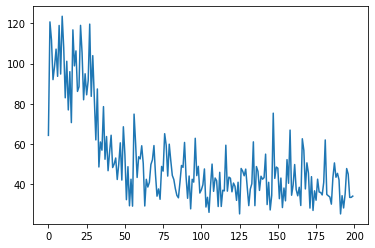

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

plt.plot(losses)

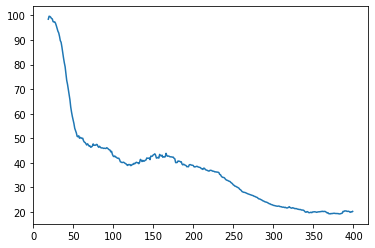

In [224]:
plt.plot(pd.Series(losses).rolling(20).mean())

In [65]:
def test_model(cur_batch):
    
    for i in range(len(all_nets)):
        all_nets[i].eval()
    
    X = stg1_net(cur_batch.float())

    X = activation(stg2_conv_block(X) + stg2_sc(X))
    X = activation(stg2_id1_block(X) + X)
    X = activation(stg2_id2_block(X) + X)
    
    X =  avg_pool(X)
    
    X = activation(stg3_conv_block(X) + stg3_sc(X))
    X = activation(stg3_id1_block(X) + X)
    X = activation(stg3_id2_block(X) + X)
    X = activation(stg3_id3_block(X) + X)
    
    X = adp_pool_s12(X)
    
    X = activation(stg4_conv_block(X) + stg4_sc(X))
    X = activation(stg4_id1_block(X) + X)
    X = activation(stg4_id2_block(X) + X)

    X = activation(stg5_conv_block(X) + stg5_sc(X))
    X = activation(stg5_id1_block(X) + X)
    X = activation(stg5_id2_block(X) + X)
    
    output = final_fc((X.view(X.size(0), -1)))
    return output


In [833]:
get_targets(1, 1), np.where(get_targets(1, 1)[:, 0]==1)

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.5072, 0.5505, 0.3894, 0.5192, 6.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [844]:
#from below
pred_bbxs = nms_fin_res(1, confidende_threshold = 0.31, iou_cutoff = 0.51)
pred_bbxs

tensor([[ 0.9214,  0.5511,  0.6594,  0.3737,  0.5243, 15.0000]],
       grad_fn=<CatBackward>)

In [842]:
first_df.iloc[:5, 10:]

,xmin_r,ymin_r,xmax_r,ymax_r,mid_x,mid_y,w_size,h_size,x_r,y_r,w_r,h_r,anchor,grid_a,grid_n,pix_pt
0,219.0,234.0,270.0,376.0,244.0,305.0,51.0,142.0,0.586538,0.733173,0.122596,0.341346,0,"(1, 2)",7,127124
1,137.0,293.0,210.0,413.0,174.0,353.0,73.0,120.0,0.418269,0.848558,0.175481,0.288462,0,"(1, 2)",7,147022
2,4.0,271.0,56.0,415.0,30.0,343.0,52.0,144.0,0.072115,0.824519,0.125000,0.346154,0,"(0, 2)",6,142718
3,201.0,215.0,245.0,332.0,223.0,274.0,45.0,116.0,0.536058,0.658654,0.108173,0.278846,0,"(1, 1)",4,114207
4,230.0,206.0,260.0,244.0,245.0,225.0,29.0,38.0,0.588942,0.540865,0.069712,0.091346,0,"(1, 1)",4,93845


In [908]:
# def write_bb(xml_id):
#     sel_img_x = first_df[first_df['xml_id'] ==xml_id].iloc[:, np.r_[1, 4, 10:16, -4, -2]]
#     pil_img = show_pil_img(sel_img_x.iloc[0, 0])
#     #trans = transforms.Compose([transforms.Resize((416, 416))])
#     im = trans(pil_img)
    
#     draw = ImageDraw.Draw(im)
#     #Draw a bounding box in resized image (using revised parameters) --> put the class of object at the center
#     for i in range(sel_img_x.shape[0]):
#         draw.rectangle(tuple(sel_img_x.iloc[i, 2:6].values), outline=(255, 255, 255))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values),sel_img_x.iloc[i, 1], stroke_width=0,  fill=(255,255,0,128))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values + (0, -10)),str(sel_img_x.iloc[i, -2]), stroke_width=0,  fill=(255,255,0,128))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values +(0, 10)),str(sel_img_x.iloc[i, -1]), stroke_width=0,  fill=(255,255,0,128))
#     return im


def write_bb_test(tgt_df_ref, pred_bbxs):
    xml_id = xml_id_sel[tgt_df_ref]
    sel_img_x = first_df[first_df['xml_id'] ==xml_id].iloc[:, np.r_[1, 4, 10:16, -4, -2]]
    pil_img = show_pil_img(sel_img_x.iloc[0, 0])
    #pil_img = show_pil_img(xml_id)
    #trans = transforms.Compose([transforms.Resize((416, 416))])
    im = trans(pil_img)
    
    draw = ImageDraw.Draw(im)
    #Draw a bounding box in resized image (using revised parameters) --> put the class of object at the center
#     for i in range(sel_img_x.shape[0]):
#         draw.rectangle(tuple(sel_img_x.iloc[i, 2:6].values), outline=(255, 255, 255))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values),sel_img_x.iloc[i, 1], stroke_width=0,  fill=(255,255,0,128))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values + (0, -10)),str(sel_img_x.iloc[i, -2]), stroke_width=0,  fill=(255,255,0,128))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values +(0, 10)),str(sel_img_x.iloc[i, -1]), stroke_width=0,  fill=(255,255,0,128))
    for i in range(pred_bbxs.shape[0]):
        xc, yc, wt, ht = tuple((pred_bbxs[i, 1:5]*416).data.tolist())
        x_low = xc - 0.5 * wt
        x_high = xc + 0.5 * wt
        y_low = xc - 0.5 * ht
        y_high = xc + 0.5 * ht
        draw.rectangle([(x_low, y_low), (x_high, y_high)], outline=(255, 255, 255))
        #draw.rectangle(tuple(pred_bbxs[0, 1:5].data.tolist()), outline=(255, 255, 255))
#         draw.rectangle([(.25, .25), (.75, .75)], outline=(255, 255, 255))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values),sel_img_x.iloc[i, 1], stroke_width=0,  fill=(255,255,0,128))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values + (0, -10)),str(sel_img_x.iloc[i, -2]), stroke_width=0,  fill=(255,255,0,128))
#         draw.text(tuple(sel_img_x.iloc[i, 6:8].values +(0, 10)),str(sel_img_x.iloc[i, -1]), stroke_width=0,  fill=(255,255,0,128))
    return im

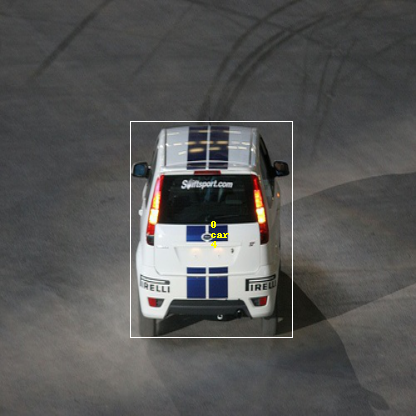

In [882]:
write_bb(6)

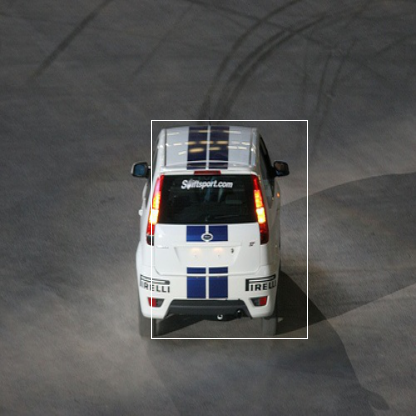

In [909]:
tgt_df_ref = 1
pred_bbxs = nms_fin_res(tgt_df_ref, confidende_threshold = 0.31, iou_cutoff = 0.51)
#pred_bbxs
write_bb_test(tgt_df_ref, pred_bbxs)

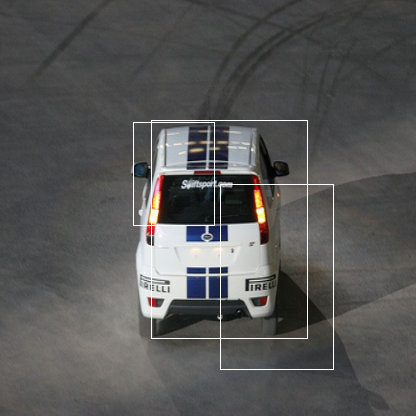

In [914]:
tgt_df_ref = 1
pred_bbxs = nms_fin_res(tgt_df_ref, confidende_threshold = 0.21, iou_cutoff = 0.1)
#pred_bbxs
write_bb_test(tgt_df_ref, pred_bbxs)

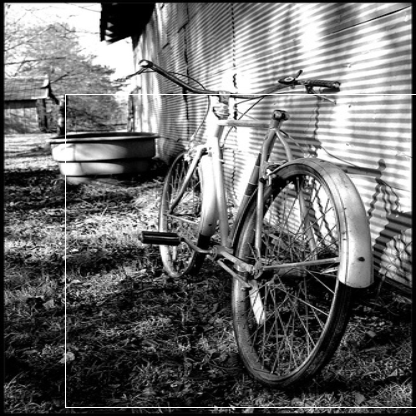

In [922]:
tgt_df_ref = 2
pred_bbxs = nms_fin_res(tgt_df_ref, confidende_threshold = 0.61, iou_cutoff = 0.71)
#pred_bbxs
write_bb_test1(tgt_df_ref, pred_bbxs)

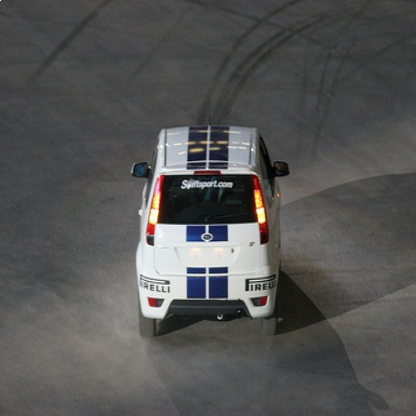

In [892]:
xml_id = xml_id_sel[tgt_df_ref]
sel_img_x = first_df[first_df['xml_id'] ==xml_id].iloc[:, np.r_[1, 4, 10:16, -4, -2]]
pil_img = show_pil_img(sel_img_x.iloc[0, 0])
#pil_img = show_pil_img(xml_id)
#trans = transforms.Compose([transforms.Resize((416, 416))])
im = trans(pil_img)

draw = ImageDraw.Draw(im)
#draw.rectangle([(125, 125), (275, 275)], outline=(255, 255, 255))
draw.rectangle(tuple(pred_bbxs[0, 1:5].data.tolist()), outline=(255, 255, 255))
im

In [434]:
#load the test image and get prediction long vector
test_batch = pil_to_arr_alt(1, 9, img_idxs)
test_pred = test_model(test_batch)

In [435]:
torch.topk(nn.Sigmoid()(test_pred.view(-1, 25)[:, 0]), 6)

torch.return_types.topk(
values=tensor([0.7205, 0.6514, 0.6029, 0.1741, 0.0841, 0.0830],
       grad_fn=<TopkBackward>),
indices=tensor([ 9,  8, 10,  6, 17, 11]))

In [413]:
#torch.topk(nn.Sigmoid()(test_pred.view(-1, 25)[:, 0]), 6)

In [436]:
torch.topk(nn.Softmax(dim =0)(test_pred.view(-1, 25)[9, 5:]), 5)

torch.return_types.topk(
values=tensor([0.5306, 0.3444, 0.0263, 0.0242, 0.0177], grad_fn=<TopkBackward>),
indices=tensor([18,  6, 13, 11,  0]))

In [437]:
nn.Sigmoid()(test_pred.view(-1, 25)[9, :5])

tensor([0.7205, 0.5518, 0.4364, 0.6747, 0.2777], grad_fn=<SigmoidBackward>)

In [212]:
nn.Sigmoid()(test_pred.view(-1, 25)[9, :5])

tensor([0.9037, 0.4757, 0.3716, 0.5562, 0.4584], grad_fn=<SigmoidBackward>)

In [197]:
torch.topk(nn.Softmax(dim =0)(test_pred.view(-1, 25)[9, 5:]), 5)

torch.return_types.topk(
values=tensor([0.4516, 0.2742, 0.2262, 0.0145, 0.0093], grad_fn=<TopkBackward>),
indices=tensor([13, 18,  6,  7, 11]))

In [91]:
#test_pred.view(-1, 25)

In [407]:
def find_ious(row_1, row_2):
    x1, y1, w1, h1 = row_1[1:5]
    x2, y2, w2, h2 = row_2[1:5]


    x1_low = torch.clamp(x1 - 0.5 * w1, 0, 1)
    x1_high = torch.clamp(x1 + 0.5 * w1, 0, 1)
    x2_low = torch.clamp(x2 - 0.5 * w2, 0, 1)
    x2_high = torch.clamp(x2 + 0.5 * w2, 0, 1)

    x_overap = min(x1_high, x2_high).item() - max(x1_low, x2_low).item()
    x_overap = max(0, x_overap)
    #print(x_overap)
    

    y1_low = torch.clamp(y1 - 0.5 * h1, 0, 1)
    y1_high = torch.clamp(y1 + 0.5 * h1, 0, 1)
    y2_low = torch.clamp(y2 - 0.5 * h2, 0, 1)
    y2_high = torch.clamp(y2 + 0.5 * h2, 0, 1)
    
    y_overap = min(y1_high, y2_high).item() - max(y1_low, y2_low).item()
    y_overap = max(0, y_overap)
    #print(y_overap)
    
    
    w1_cor = x1_high - x1_low
    h1_cor = y1_high - y1_low
    w2_cor = x2_high - x2_low
    h2_cor = y2_high - y2_low

    aoi = x_overap * y_overap
    iou = aoi / (w1_cor * h1_cor + (w2_cor * h2_cor) -aoi)
    return iou

In [405]:
row_b = torch.tensor([.9, .2, .2, .5, .5])
row_a = torch.tensor([.9, .1, .1, .5, .5])

In [406]:
find_ious(row_a, row_b)

0.3499999940395355
0.3499999940395355


tensor(0.6049)

In [438]:
# test_pred
# new_test = test_pred.view(-1, 25).clone()
# new_test[:, :5] = nn.Sigmoid()(new_test[:, :5])
# new_test[:, 5:] = nn.Softmax(dim = 0)(new_test[:, 5:])

# new_test2 = torch.zeros(18, 6)
# new_test2[:, :5] = new_test[:, :5]
# new_test2[:, 5] = (torch.topk(nn.Softmax(dim = 0)(new_test[:, 5:]), 1)[1]).squeeze()
# new_test2[:, 5] =(new_test2[:, 5]).int()

In [809]:
#Give a starter index (just index) and get the predicted and processed tensor
#Note the size of tensor is <= (18, 6) as some will have confidence below cut-off
def process_test_img(startiing_idx, bs = 1, confidende_threshold = 0.01):
    #test_batch = pil_to_arr_alt(1, 9, img_idxs)
    
    test_batch = pil_to_arr_alt(1, startiing_idx, img_idxs)  #bs is kept 1 for now
    test_pred = test_model(test_batch)

    #post processsing to get predictions in desired range/form
    #get the center and size between 0 - 1, --> as used in loss function
    new_test = test_pred.view(-1, 25).clone()
    new_test[:, :5] = nn.Sigmoid()(new_test[:, :5])
    new_test[:, 5:] = nn.Softmax(dim = 0)(new_test[:, 5:])

    #From the 20 score, find one with highers probablitu --> prediction for object (selecting just top one)
    new_test2 = torch.zeros(18, 6)
    new_test2[:, :5] = new_test[:, :5]
    new_test2[:, 5] = (torch.topk(nn.Softmax(dim = 0)(new_test[:, 5:]), 1)[1]).squeeze()
    new_test2[:, 5] =(new_test2[:, 5]).int()

    #Discard all objects with confidence score below some threshold
    new_test2 = new_test2[new_test2[:, 0]> confidende_threshold]
    return new_test2

In [808]:
def find_duplicates_old(processed_pred):
    counts_dict = collections.Counter(processed_pred[:, -1].tolist())
    obj_occ_arr = np.array(counts_dict.most_common())
    #print(obj_occ_arr)
    dup_objs_ix = np.where(obj_occ_arr[:, 1] > 1)
    obj_n_counts = obj_occ_arr[dup_objs_ix, :]
    dup_objs = obj_n_counts.squeeze()[:, 0]
    dup_objs = dup_objs.tolist()
    
    sing_objs_ix = np.where(obj_occ_arr[:, 1] == 1)
    Sing_obj_n_counts = obj_occ_arr[sing_objs_ix, :]
    sing_objs = Sing_obj_n_counts.squeeze()[:, 0]
    sing_objs = sing_objs.tolist()
    #print(dup_objs, sing_objs)
    return (dup_objs, sing_objs)

def find_duplicates(processed_pred):
    counts_dict = collections.Counter(processed_pred[:, -1].tolist())
    obj_occ_arr = np.array(counts_dict.most_common())
    dup_objs_ix = np.where(obj_occ_arr[:, 1] > 1)
    obj_n_counts = obj_occ_arr[dup_objs_ix, :]
    
    dup_objs = obj_n_counts.reshape(-1, 2)[:, 0]
    dup_objs = dup_objs.tolist()
    
    sing_objs_ix = np.where(obj_occ_arr[:, 1] == 1)
    sing_obj_n_counts = obj_occ_arr[sing_objs_ix, :]
    
    sing_objs = sing_obj_n_counts.reshape(-1, 2)[:, 0]
    sing_objs = sing_objs.tolist()
    return (dup_objs, sing_objs)

In [ ]:
def sel_rowss(obj_group, iou_cutoff):
    rows_in = obj_group[0]

    overlaps = [0]
    for i in range(len(obj_group) -1):
        cur_iou = find_ious(obj_group[0], obj_group[i+1])
        overlaps.append(cur_iou.item())
    #overlaps
    rows_out_idx = np.where(np.array(overlaps) > iou_cutoff)
    rows_redo_idx = np.where(np.array(overlaps) <= iou_cutoff)[0][1:]
    redo_rows = obj_group[rows_redo_idx, :]
    return(rows_in, redo_rows, overlaps)

In [ ]:
def nmsupp(obj_tensor, iou_cutoff):
    group_x = obj_tensor.clone()
    group_x = group_x[torch.argsort(-group_x[:, 0]), :]  #sort it
    collect_rows = torch.tensor([])
    overlaps =['a', 'b', 'c']  #just a dummy to keep initiate size of overlap --> keep it above 2
    
    while len(overlaps) > 2:
        rows_in, group_x, overlaps = sel_rowss(group_x, iou_cutoff)
        collect_rows = torch.cat((collect_rows, rows_in.view(-1, 6)), 0)
        
    if overlaps[-1] < iou_cutoff:
        collect_rows = torch.cat((collect_rows, group_x), 0)
    return collect_rows

In [724]:
process_test_img(9, bs = 1, confidende_threshold = 0.01)

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.6000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.2000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 3.0000e+00],
        [1.5530e-02, 5.5055e-01, 1.7742e-01, 8.8893e-01, 2.6654e-01, 1.3000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 6.0000e+00],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 0.0000e+00],
        [2.2625e-02, 2.1752e-01, 6.6678e-01, 3.6965e-01, 1.4929e-01, 5.0000e+00],
        [6.5144e-01, 5.1920e-01, 5.3788e-01, 5.6012e-01, 6.4998e-01, 1.0000e+00],
        [7.2054e-01, 5.5180e-01, 4.3638e-01, 6.7466e-01, 2.7773e-01, 1.8000e+01],
        [6.0286e-01, 7.9518e-01, 5.6313e-01, 2.6159e-01, 5.4385e-01, 8.0000e+00],
        [8.3048e-02, 7.6161e-01, 5.2281e-01, 5.5678e-01, 3.8818e-01, 1.8000e+01],
        [3.2526e

In [758]:
#####################################################
#Functions use --> process_test_img (--> pil_to_arr_alt, test_model), find_duplicates, nmsupp(-->sel_rowss(--> find_ious))
starter = process_test_img(10, bs = 1, confidende_threshold = 0.01)
fin_res = torch.tensor([])  #Get all the results here

#Find the whether selected objects or have multiple copies
multi_copies, lone_obj = find_duplicates(starter) 

#All lone objects automatically selected for final result
rows_ixs_sing_obj = [np.where(starter[:, -1]== lone_obj[i])[0][0] for i in range(len(lone_obj))]
rows_sing_obj = starter[rows_ixs_sing_obj, :]
fin_res = torch.cat((fin_res, rows_sing_obj), 0)

#Use non-max suppression to filter out those with significant overlaps
#Start with the image having highest confidence
for i in range(len(multi_copies)):
    obj_tensor = (starter[starter[:, -1] == multi_copies[i]]).clone()
    temp = nmsupp(obj_tensor, iou_cutoff)
    fin_res = torch.cat((fin_res, temp), 0)
    
#Print the final result
fin_res

########################################################################

tensor([[5.2599e-02, 1.4325e-01, 2.5257e-01, 2.0140e-01, 2.9150e-01, 1.9000e+01],
        [1.2216e-01, 2.5920e-01, 3.8439e-01, 1.8117e-01, 1.7437e-01, 3.0000e+00],
        [1.5788e-02, 1.9430e-01, 5.7140e-01, 4.0391e-01, 1.5506e-01, 5.0000e+00],
        [6.5128e-02, 7.8811e-01, 4.9926e-01, 3.3816e-01, 3.7383e-01, 7.0000e+00],
        [1.4854e-02, 2.2267e-01, 9.2299e-01, 3.3725e-01, 2.6858e-01, 9.0000e+00],
        [2.1905e-01, 4.5003e-01, 8.9781e-01, 8.8706e-01, 3.3180e-01, 1.0000e+01],
        [2.5894e-02, 7.7699e-01, 7.9760e-01, 4.5951e-01, 3.4649e-01, 2.0000e+00],
        [6.5436e-01, 5.0152e-01, 4.6117e-01, 5.4183e-01, 7.7164e-01, 1.2000e+01],
        [1.2905e-02, 1.2648e-01, 1.7064e-01, 1.4687e-01, 1.0071e-01, 1.2000e+01],
        [1.5377e-02, 8.4148e-01, 1.0567e-01, 1.2732e-01, 3.1896e-01, 1.5000e+01],
        [4.1168e-01, 5.7934e-01, 4.2931e-01, 9.4060e-01, 6.1807e-01, 6.0000e+00],
        [6.6700e-01, 7.0093e-01, 4.4277e-01, 4.1188e-01, 7.0118e-01, 1.4000e+01],
        [5.0479e

In [756]:
starter[:7, -1] = 14.0
starter

tensor([[5.2599e-02, 1.4325e-01, 2.5257e-01, 2.0140e-01, 2.9150e-01, 1.4000e+01],
        [1.2905e-02, 1.2648e-01, 1.7064e-01, 1.4687e-01, 1.0071e-01, 1.4000e+01],
        [1.2216e-01, 2.5920e-01, 3.8439e-01, 1.8117e-01, 1.7437e-01, 1.4000e+01],
        [1.2058e-02, 5.7061e-01, 1.4876e-01, 8.7074e-01, 3.3773e-01, 1.4000e+01],
        [1.5377e-02, 8.4148e-01, 1.0567e-01, 1.2732e-01, 3.1896e-01, 1.4000e+01],
        [2.5376e-02, 9.2405e-01, 4.0056e-01, 1.4562e-01, 1.5731e-01, 1.4000e+01],
        [5.0479e-01, 2.6081e-01, 4.9587e-01, 3.1955e-01, 6.1786e-01, 1.4000e+01],
        [1.5788e-02, 1.9430e-01, 5.7140e-01, 4.0391e-01, 1.5506e-01, 5.0000e+00],
        [6.5436e-01, 5.0152e-01, 4.6117e-01, 5.4183e-01, 7.7164e-01, 1.2000e+01],
        [4.1168e-01, 5.7934e-01, 4.2931e-01, 9.4060e-01, 6.1807e-01, 6.0000e+00],
        [6.6700e-01, 7.0093e-01, 4.4277e-01, 4.1188e-01, 7.0118e-01, 1.4000e+01],
        [6.5128e-02, 7.8811e-01, 4.9926e-01, 3.3816e-01, 3.7383e-01, 7.0000e+00],
        [1.4854e

In [810]:
def nms_fin_res(img_num, confidende_threshold = 0.01, iou_cutoff = 0.01):
    #Functions use --> process_test_img (--> pil_to_arr_alt, test_model), find_duplicates, nmsupp(-->sel_rowss(--> find_ious))
    
    starter = process_test_img(img_num, 1, confidende_threshold) #bs = 1, kept 1 for now
    fin_res = torch.tensor([])  #Get all the results here

    #Find the whether selected objects or have multiple copies
    multi_copies, lone_obj = find_duplicates(starter)

    #All lone objects automatically selected for final result
    rows_ixs_sing_obj = [np.where(starter[:, -1]== lone_obj[i])[0][0] for i in range(len(lone_obj))]
    rows_sing_obj = starter[rows_ixs_sing_obj, :]
    fin_res = torch.cat((fin_res, rows_sing_obj), 0)

    #Use non-max suppression to filter out those with significant overlaps
    #Start with the image having highest confidence
    for i in range(len(multi_copies)):
        obj_tensor = (starter[starter[:, -1] == multi_copies[i]])#.clone()
        temp = nmsupp(obj_tensor, iou_cutoff)
        fin_res = torch.cat((fin_res, temp), 0)

    return fin_res

In [818]:
nms_fin_res(9, confidende_threshold = 0.51, iou_cutoff = 0.51)

tensor([[ 0.6514,  0.5192,  0.5379,  0.5601,  0.6500,  1.0000],
        [ 0.7205,  0.5518,  0.4364,  0.6747,  0.2777, 18.0000],
        [ 0.6029,  0.7952,  0.5631,  0.2616,  0.5438,  8.0000]],
       grad_fn=<CatBackward>)

In [ ]:
#The End
#The End
#The End

In [640]:
#############################################################
confidende_threshold = 0.01


#load the test image and get prediction long vector
test_batch = pil_to_arr_alt(1, 9, img_idxs)
test_pred = test_model(test_batch)

#post processsing to get predictions in desired range/form
#get the center and size between 0 - 1, --> as used in loss function
new_test = test_pred.view(-1, 25).clone()
new_test[:, :5] = nn.Sigmoid()(new_test[:, :5])
new_test[:, 5:] = nn.Softmax(dim = 0)(new_test[:, 5:])

#From the 20 score, find one with highers probablitu --> prediction for object (selecting just top one)
new_test2 = torch.zeros(18, 6)
new_test2[:, :5] = new_test[:, :5]
new_test2[:, 5] = (torch.topk(nn.Softmax(dim = 0)(new_test[:, 5:]), 1)[1]).squeeze()
new_test2[:, 5] =(new_test2[:, 5]).int()

#Discard all objects with confidence score below some threshold
new_test2 = new_test2[new_test2[:, 0]> confidende_threshold]



In [719]:
fin_res = torch.tensor([])
multi_copies, lone_obj = find_duplicates(new_test2)
rows_ixs_sing_obj = [np.where(new_test2[:, -1]== lone_obj[i])[0][0] for i in range(len(lone_obj))]
rows_sing_obj = new_test2[rows_ixs_sing_obj, :]
fin_res = torch.cat((fin_res, rows_sing_obj), 0)
fin_res

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.6000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.2000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 6.0000e+00],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 0.0000e+00],
        [2.2625e-02, 2.1752e-01, 6.6678e-01, 3.6965e-01, 1.4929e-01, 5.0000e+00],
        [6.5144e-01, 5.1920e-01, 5.3788e-01, 5.6012e-01, 6.4998e-01, 1.0000e+00],
        [6.0286e-01, 7.9518e-01, 5.6313e-01, 2.6159e-01, 5.4385e-01, 8.0000e+00],
        [3.2526e-02, 1.7856e-01, 7.7552e-01, 2.4245e-01, 4.3975e-01, 4.0000e+00],
        [3.3898e-02, 2.2580e-01, 7.7959e-01, 4.4722e-01, 2.3490e-01, 9.0000e+00],
        [3.2541e-02, 8.4330e-01, 8.2328e-01, 1.8414e-01, 3.7076e-01, 1.1000e+01],
        [8.4058e-02, 7.8965e-01, 7.8818e-01, 4.6426e-01, 2.7835e-01, 2.0000e+00]],
       grad_fn=

In [720]:
#cache = torch.tensor([])
for i in range(len(multi_copies)):
    obj_tensor = (new_test2[new_test2[:, -1] == multi_copies[i]]).clone()
    #print(nmsupp(obj_tensor, iou_cutoff))
    temp = nmsupp(obj_tensor, iou_cutoff)
    #cache = torch.cat((cache, temp), 0)
    fin_res = torch.cat((fin_res, temp), 0)
fin_res

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.6000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.2000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 6.0000e+00],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 0.0000e+00],
        [2.2625e-02, 2.1752e-01, 6.6678e-01, 3.6965e-01, 1.4929e-01, 5.0000e+00],
        [6.5144e-01, 5.1920e-01, 5.3788e-01, 5.6012e-01, 6.4998e-01, 1.0000e+00],
        [6.0286e-01, 7.9518e-01, 5.6313e-01, 2.6159e-01, 5.4385e-01, 8.0000e+00],
        [3.2526e-02, 1.7856e-01, 7.7552e-01, 2.4245e-01, 4.3975e-01, 4.0000e+00],
        [3.3898e-02, 2.2580e-01, 7.7959e-01, 4.4722e-01, 2.3490e-01, 9.0000e+00],
        [3.2541e-02, 8.4330e-01, 8.2328e-01, 1.8414e-01, 3.7076e-01, 1.1000e+01],
        [8.4058e-02, 7.8965e-01, 7.8818e-01, 4.6426e-01, 2.7835e-01, 2.0000e+00],
        [5.2307e

In [713]:
multi, sing = find_duplicates(new_test2)
np.where(np.array(collections.Counter(new_test2[:, -1].tolist()).most_common())[:, 1] == 1)

[[ 3.  2.]
 [13.  2.]
 [18.  2.]
 [16.  1.]
 [12.  1.]
 [14.  1.]
 [ 6.  1.]
 [ 0.  1.]
 [ 5.  1.]
 [ 1.  1.]
 [ 8.  1.]
 [ 4.  1.]
 [ 9.  1.]
 [11.  1.]
 [ 2.  1.]]
[3.0, 13.0, 18.0] [16.0, 12.0, 14.0, 6.0, 0.0, 5.0, 1.0, 8.0, 4.0, 9.0, 11.0, 2.0]


(array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64),)

In [716]:
multi, sing

([3.0, 13.0, 18.0],
 [16.0, 12.0, 14.0, 6.0, 0.0, 5.0, 1.0, 8.0, 4.0, 9.0, 11.0, 2.0])

In [685]:
#new_test2[np.where(new_test2[:, -1]==[16, 12])]#[[16.0, 12.0, 14.0, 6.0, 0.0, 5.0, 1.0, 8.0, 4.0, 9.0, 11.0, 2.0]]]#.shape
#np.where(new_test2[:, -1]==(16, 12))
[new_test2[new_test2[:, -1]==[16.0, 12.0, 14.0, 6.0, 0.0, 5.0, 1.0, 8.0, 4.0, 9.0, 11.0, 2.0][i]] for i in range(3)]

[tensor([[ 0.0184,  0.0677,  0.1026,  0.1409,  0.1511, 16.0000]],
        grad_fn=<IndexBackward>),
 tensor([[1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.2000e+01]],
        grad_fn=<IndexBackward>),
 tensor([[ 0.0202,  0.7609,  0.1260,  0.0893,  0.1948, 14.0000]],
        grad_fn=<IndexBackward>)]

In [711]:
# lll = [16.0, 12.0, 14.0, 6.0, 0.0, 5.0, 1.0, 8.0, 4.0, 9.0, 11.0, 2.0]
# [np.where(new_test2[:, -1]==lll[i] for i in range(len(lll)))]
rows_sing_obj = [np.where(new_test2[:, -1]== lll[i])[0][0] for i in range(len(lll))]
[np.where(new_test2[:, -1]== lll[i])[0][0] for i in range(len(lll))]

[0, 1, 4, 5, 6, 7, 8, 10, 12, 13, 16, 17]

In [712]:
new_test2[rows_sing_obj, :]

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.6000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.2000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 6.0000e+00],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 0.0000e+00],
        [2.2625e-02, 2.1752e-01, 6.6678e-01, 3.6965e-01, 1.4929e-01, 5.0000e+00],
        [6.5144e-01, 5.1920e-01, 5.3788e-01, 5.6012e-01, 6.4998e-01, 1.0000e+00],
        [6.0286e-01, 7.9518e-01, 5.6313e-01, 2.6159e-01, 5.4385e-01, 8.0000e+00],
        [3.2526e-02, 1.7856e-01, 7.7552e-01, 2.4245e-01, 4.3975e-01, 4.0000e+00],
        [3.3898e-02, 2.2580e-01, 7.7959e-01, 4.4722e-01, 2.3490e-01, 9.0000e+00],
        [3.2541e-02, 8.4330e-01, 8.2328e-01, 1.8414e-01, 3.7076e-01, 1.1000e+01],
        [8.4058e-02, 7.8965e-01, 7.8818e-01, 4.6426e-01, 2.7835e-01, 2.0000e+00]],
       grad_fn=

In [688]:
new_test2

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.6000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.2000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 3.0000e+00],
        [1.5530e-02, 5.5055e-01, 1.7742e-01, 8.8893e-01, 2.6654e-01, 1.3000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 6.0000e+00],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 0.0000e+00],
        [2.2625e-02, 2.1752e-01, 6.6678e-01, 3.6965e-01, 1.4929e-01, 5.0000e+00],
        [6.5144e-01, 5.1920e-01, 5.3788e-01, 5.6012e-01, 6.4998e-01, 1.0000e+00],
        [7.2054e-01, 5.5180e-01, 4.3638e-01, 6.7466e-01, 2.7773e-01, 1.8000e+01],
        [6.0286e-01, 7.9518e-01, 5.6313e-01, 2.6159e-01, 5.4385e-01, 8.0000e+00],
        [8.3048e-02, 7.6161e-01, 5.2281e-01, 5.5678e-01, 3.8818e-01, 1.8000e+01],
        [3.2526e

In [587]:
new_test2[:7, -1] = 14

In [444]:
new_test2.shape

torch.Size([18, 6])

In [445]:
np.where(new_test2[:, 0] > .001)  #Get the ones which confidence higher than 0.01

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17], dtype=int64),)

In [446]:
len(list(set((new_test2[:, -1]).tolist())))

11

In [447]:
#group the ones which higher rows having same objects
import collections
collections.Counter(new_test2[:, -1].tolist())

Counter({14.0: 7,
         5.0: 1,
         1.0: 1,
         18.0: 2,
         8.0: 1,
         4.0: 1,
         9.0: 1,
         13.0: 1,
         3.0: 1,
         11.0: 1,
         2.0: 1})

In [448]:
counts_dict = collections.Counter(new_test2[:, -1].tolist())

In [595]:

#dup_objs_ix, obj_occ_arr

[14.0, 7.0]

In [666]:
counts_dict.most_common()

[(14.0, 7),
 (18.0, 2),
 (5.0, 1),
 (1.0, 1),
 (8.0, 1),
 (4.0, 1),
 (9.0, 1),
 (13.0, 1),
 (3.0, 1),
 (11.0, 1),
 (2.0, 1)]

In [450]:
np.array(counts_dict.most_common())#[1, :] > 1

array([[14.,  7.],
       [18.,  2.],
       [ 5.,  1.],
       [ 1.,  1.],
       [ 8.,  1.],
       [ 4.,  1.],
       [ 9.,  1.],
       [13.,  1.],
       [ 3.,  1.],
       [11.,  1.],
       [ 2.,  1.]])

In [451]:
obj_occ_arr = np.array(counts_dict.most_common())

In [452]:
np.where(np.array(counts_dict.most_common())[1, :] > 1)

(array([0, 1], dtype=int64),)

In [453]:
dup_objs_ix = np.where(np.array(counts_dict.most_common())[1, :] > 1)

In [454]:
dup_objs_ix

(array([0, 1], dtype=int64),)

In [455]:
dup_counts = obj_occ_arr[dup_objs_ix, :].reshape(-1, 2)
obj_occ_arr[dup_objs_ix, :].reshape(-1, 2)

array([[14.,  7.],
       [18.,  2.]])

In [456]:
#Now we know only rows with object 19 and 7 has to go through non max suppression
dup_counts[:, 0]

array([14., 18.])

In [521]:
group_a = new_test2[new_test2[:, -1] == (dup_counts[:, 0][0])]#[0]
group_a

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [1.5530e-02, 5.5055e-01, 1.7742e-01, 8.8893e-01, 2.6654e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>)

In [463]:
find_ious(new_test2[new_test2[:, -1] == (dup_counts[:, 0][0])][0], new_test2[new_test2[:, -1] == (dup_counts[:, 0][0])][6])

tensor(0., grad_fn=<MulBackward0>)

In [403]:
new_test2[new_test2[:, -1] == (dup_counts[:, 0][0])][0], new_test2[new_test2[:, -1] == (dup_counts[:, 0][0])][1]

(tensor([ 0.0698,  0.2604,  0.4716,  0.0904,  0.0630, 19.0000],
        grad_fn=<SelectBackward>),
 tensor([1.1511e-02, 9.2297e-01, 8.6311e-01, 2.1275e-01, 3.2850e-01, 1.9000e+01],
        grad_fn=<SelectBackward>))

In [473]:
#x_overap = min(x1_high, x2_high).item() - max(x1_low, x2_low).item()
overlaps = [0]
for i in range(len(group_a) -1):
    #print(find_ious(group_a[0], group_a[i+1]))
    cur_iou = find_ious(group_a[0], group_a[i+1])
    overlaps.append(cur_iou.item())
overlaps

[0, 0.0, 0.0, 0.01695374771952629, 0.0, 0.0, 0.0]

In [475]:
np.where(np.array(overlaps) > 0.01), np.where(np.array(overlaps) <= 0.01)

((array([3], dtype=int64),), (array([0, 1, 2, 4, 5, 6], dtype=int64),))

In [476]:
group_a[[1, 2, 4, 5, 6], :]

tensor([[1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>)

In [503]:
sel_rowss(group_a, .01)

tensor([[1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>)

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [1.5530e-02, 5.5055e-01, 1.7742e-01, 8.8893e-01, 2.6654e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>)

In [538]:
group_b = group_a.clone()
collect_rows = torch.tensor([])
for i in range(5):
    rows_in, group_b, overlaps = sel_rowss(group_b.clone(), .01)
    collect_rows = torch.cat((collect_rows, rows_in), 0)
    print(rows_in, group_b, overlaps)

tensor([ 0.0184,  0.0677,  0.1026,  0.1409,  0.1511, 14.0000],
       grad_fn=<SelectBackward>) tensor([[1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>) [0, 0.0, 0.0, 0.01695374771952629, 0.0, 0.0, 0.0]
tensor([1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
       grad_fn=<SelectBackward>) tensor([[ 0.0523,  0.4780,  0.2416,  0.0893,  0.2068, 14.0000],
        [ 0.0202,  0.7609,  0.1260,  0.0893,  0.1948, 14.0000],
        [ 0.0193,  0.8618,  0.3345,  0.2147,  0.2203, 14.0000],
        [ 0.1741,  0.2637,  0.5628,  0.2727,  0.3949, 14.0000]],
       grad_fn=<IndexBackward>) [0, 0.0,

In [536]:
# group_b = group_a.clone()
# collect_rows = torch.tensor([])
# def get_all_rows(group_b):
#     rows_in, group_b, overlaps = sel_rowss(group_b.clone(), .01)
#     #for i in range(5):
#     collect_rows = torch.cat((collect_rows, rows_in), 0)
#     print(rows_in, group_b, overlaps)

In [574]:
group_b = group_a.clone()
collect_rows = torch.tensor([])#.reshape(-1, 6)
iou_cutoff = 0.01
#for i in range(5):
overlaps =['a', 'b', 'c']
counter = 0
#rows_in, group_b, overlaps = sel_rowss(group_b.clone(), .01)
while len(overlaps) > 2:
    rows_in, group_b, overlaps = sel_rowss(group_b.clone(), iou_cutoff)
    collect_rows = torch.cat((collect_rows, rows_in.view(-1, 6)), 0)
    print(rows_in, group_b, overlaps)
if overlaps[-1] < iou_cutoff:
    collect_rows = torch.cat((collect_rows, group_b), 0)

tensor([ 0.0184,  0.0677,  0.1026,  0.1409,  0.1511, 14.0000],
       grad_fn=<SelectBackward>) tensor([[1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>) [0, 0.0, 0.0, 0.01695374771952629, 0.0, 0.0, 0.0]
tensor([1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
       grad_fn=<SelectBackward>) tensor([[ 0.0523,  0.4780,  0.2416,  0.0893,  0.2068, 14.0000],
        [ 0.0202,  0.7609,  0.1260,  0.0893,  0.1948, 14.0000],
        [ 0.0193,  0.8618,  0.3345,  0.2147,  0.2203, 14.0000],
        [ 0.1741,  0.2637,  0.5628,  0.2727,  0.3949, 14.0000]],
       grad_fn=<IndexBackward>) [0, 0.0,

In [575]:
collect_rows#.shape

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<CatBackward>)

In [564]:
group_b.shape, overlaps[-1]<0.01

(torch.Size([1, 6]), True)

In [552]:
rows_in.shape

torch.Size([6])

In [584]:
group_c = nmsupp(group_a, 0.01)#.shape
nmsupp(group_c[:2], 0.01)

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01]],
       grad_fn=<CatBackward>)

In [581]:
group_a.shape

torch.Size([7, 6])

In [609]:
counts_dict = collections.Counter(new_test2[:, -1].tolist())
obj_occ_arr = np.array(counts_dict.most_common())
dup_objs_ix = np.where(np.array(counts_dict.most_common())[1, :] > 1)
obj_n_counts = obj_occ_arr[dup_objs_ix, :]
#obj_n_counts.squeeze()
dup_objs = obj_n_counts.squeeze()[:, 0]
dup_objs = dup_objs.tolist()
dup_objs

[14.0, 18.0]

In [622]:
find_duplicates(new_test2)

[14.0, 18.0]

In [629]:
cache = torch.tensor([])
for i in range(len(dup_objs)):
    obj_tensor = (new_test2[new_test2[:, -1] == dup_objs[i]]).clone()
    #print(nmsupp(obj_tensor, iou_cutoff))
    temp = nmsupp(obj_tensor, iou_cutoff)
    cache = torch.cat((cache, temp), 0)
cache

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01],
        [7.2054e-01, 5.5180e-01, 4.3638e-01, 6.7466e-01, 2.7773e-01, 1.8000e+01]],
       grad_fn=<CatBackward>)

In [631]:
cache = torch.tensor([])
for i in range(len(dup_objs)):
    obj_tensor = (new_test2[new_test2[:, -1] == dup_objs[i]]).clone()
    #print(nmsupp(obj_tensor, iou_cutoff))
    temp = nmsupp(obj_tensor, iou_cutoff)
    cache = torch.cat((cache, temp), 0)
cache

tensor([[1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [7.2054e-01, 5.5180e-01, 4.3638e-01, 6.7466e-01, 2.7773e-01, 1.8000e+01]],
       grad_fn=<CatBackward>)

In [605]:
new_test2[new_test2[:, -1] == 7.0]

tensor([], size=(0, 6), grad_fn=<IndexBackward>)

In [618]:
collect_rows

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<CatBackward>)

In [623]:
group_a

tensor([[1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [1.5530e-02, 5.5055e-01, 1.7742e-01, 8.8893e-01, 2.6654e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>)

In [626]:
torch.argsort(-group_a[:, 0]), torch.argsort(group_a[:, 0]), (group_a[:, 0])
#torch.argsort(-sorted_tensor[:, 0])

(tensor([6, 2, 4, 5, 0, 3, 1]),
 tensor([1, 3, 0, 5, 4, 2, 6]),
 tensor([0.0184, 0.0111, 0.0523, 0.0155, 0.0202, 0.0193, 0.1741],
        grad_fn=<SelectBackward>))

In [627]:
#sorted_tensor = sorted_tensor[torch.argsort(-sorted_tensor[:, 0]), :]
group_a[torch.argsort(-group_a[:, 0]), :]

tensor([[1.7408e-01, 2.6370e-01, 5.6284e-01, 2.7274e-01, 3.9492e-01, 1.4000e+01],
        [5.2307e-02, 4.7795e-01, 2.4161e-01, 8.9279e-02, 2.0682e-01, 1.4000e+01],
        [2.0174e-02, 7.6085e-01, 1.2599e-01, 8.9296e-02, 1.9485e-01, 1.4000e+01],
        [1.9325e-02, 8.6178e-01, 3.3451e-01, 2.1465e-01, 2.2035e-01, 1.4000e+01],
        [1.8410e-02, 6.7694e-02, 1.0264e-01, 1.4092e-01, 1.5109e-01, 1.4000e+01],
        [1.5530e-02, 5.5055e-01, 1.7742e-01, 8.8893e-01, 2.6654e-01, 1.4000e+01],
        [1.1064e-02, 7.6502e-02, 2.7647e-01, 1.7006e-01, 1.0213e-01, 1.4000e+01]],
       grad_fn=<IndexBackward>)

In [791]:
# def find_duplicates(processed_pred):
#     counts_dict = collections.Counter(processed_pred[:, -1].tolist())
#     obj_occ_arr = np.array(counts_dict.most_common())
#     #print(obj_occ_arr)
#     dup_objs_ix = np.where(obj_occ_arr[:, 1] > 1)
#     obj_n_counts = obj_occ_arr[dup_objs_ix, :]
#     #dup_objs = obj_n_counts[0][0]
#     print(obj_n_counts)
#     #dup_objs = obj_n_counts.squeeze()[:, 0]
#     dup_objs = obj_n_counts.reshape(-1, 2)[:, 0]
#     dup_objs = dup_objs.tolist()
    
#     sing_objs_ix = np.where(obj_occ_arr[:, 1] == 1)
#     sing_obj_n_counts = obj_occ_arr[sing_objs_ix, :]
#     print(sing_obj_n_counts)
#     #sing_objs = sing_obj_n_counts.squeeze()[:, 0]
#     sing_objs = sing_obj_n_counts.reshape(-1, 2)[:, 0]
#     sing_objs = sing_objs.tolist()
#     #print(dup_objs, sing_objs)
#     return (dup_objs, sing_objs)

In [792]:
starter[10:15, -1] = 9
find_duplicates(starter)

[[[12.  6.]
  [ 9.  5.]]]
[[[13.  1.]
  [15.  1.]
  [ 5.  1.]
  [ 6.  1.]]]


([12.0, 9.0], [13.0, 15.0, 5.0, 6.0])

In [793]:
starter#.shape

tensor([[5.2599e-02, 1.4325e-01, 2.5257e-01, 2.0140e-01, 2.9150e-01, 1.2000e+01],
        [1.2905e-02, 1.2648e-01, 1.7064e-01, 1.4687e-01, 1.0071e-01, 1.2000e+01],
        [1.2216e-01, 2.5920e-01, 3.8439e-01, 1.8117e-01, 1.7437e-01, 1.2000e+01],
        [1.2058e-02, 5.7061e-01, 1.4876e-01, 8.7074e-01, 3.3773e-01, 1.2000e+01],
        [1.5377e-02, 8.4148e-01, 1.0567e-01, 1.2732e-01, 3.1896e-01, 1.2000e+01],
        [2.5376e-02, 9.2405e-01, 4.0056e-01, 1.4562e-01, 1.5731e-01, 1.3000e+01],
        [5.0479e-01, 2.6081e-01, 4.9587e-01, 3.1955e-01, 6.1786e-01, 1.5000e+01],
        [1.5788e-02, 1.9430e-01, 5.7140e-01, 4.0391e-01, 1.5506e-01, 5.0000e+00],
        [6.5436e-01, 5.0152e-01, 4.6117e-01, 5.4183e-01, 7.7164e-01, 1.2000e+01],
        [4.1168e-01, 5.7934e-01, 4.2931e-01, 9.4060e-01, 6.1807e-01, 6.0000e+00],
        [6.6700e-01, 7.0093e-01, 4.4277e-01, 4.1188e-01, 7.0118e-01, 9.0000e+00],
        [6.5128e-02, 7.8811e-01, 4.9926e-01, 3.3816e-01, 3.7383e-01, 9.0000e+00],
        [1.4854e